In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive, files # google colab specific
import requests
import pandas as pd
import os
import warnings
import sys
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras import layers
import math
from sklearn.metrics import mean_squared_error

In [26]:
# Read in the csv file that contains the time series data of the Shiller Index
# Create the dataframe

df = pd.read_csv('/content/drive/MyDrive/JPM/jphomevalue/jphomevalue/data/shiller/shiller_split/shiller_upward.csv')
df.head()

,s_no,DATE,TPXRSA
0,0,2012-02,126.265187
1,1,2012-03,127.055604
2,2,2012-04,128.918919
3,3,2012-05,130.370998
4,4,2012-06,131.672439


In [27]:
# Reset the index based on the prices
df1 = df.reset_index()['TPXRSA']
df1

0      126.265187
1      127.055604
2      128.918919
3      130.370998
4      131.672439
          ...    
102    235.632918
103    238.226820
104    241.910433
105    245.020717
106    248.775518
Name: TPXRSA, Length: 107, dtype: float64

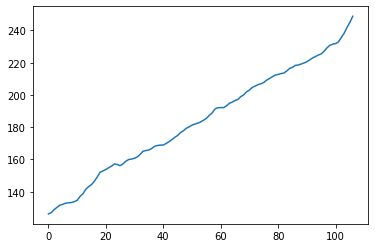

In [28]:
# Visualize the data for reference. 
plt.plot(df1)

In [29]:
# Normalize the data with the range 0 - 1
scaler = MinMaxScaler(feature_range=(0,1))

# Apply the scaler to the dataframe
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Print df1 to check the change
print(df1)

[[0.        ]
 [0.00645184]
 [0.02166129]
 [0.033514  ]
 [0.04413711]
 [0.0483963 ]
 [0.05451133]
 [0.05629725]
 [0.05760311]
 [0.06204435]
 [0.06866779]
 [0.08799684]
 [0.10145606]
 [0.12436843]
 [0.13805083]
 [0.14836015]
 [0.16503295]
 [0.18651196]
 [0.21066518]
 [0.21763751]
 [0.22455918]
 [0.23380061]
 [0.24178035]
 [0.25304794]
 [0.24986812]
 [0.24416401]
 [0.25392203]
 [0.26683066]
 [0.27534496]
 [0.27758053]
 [0.28197129]
 [0.28836109]
 [0.30204057]
 [0.31761384]
 [0.32069882]
 [0.32329223]
 [0.33123812]
 [0.34228245]
 [0.34622957]
 [0.34812697]
 [0.34838004]
 [0.35624617]
 [0.36548836]
 [0.37580048]
 [0.38727424]
 [0.39696401]
 [0.41148789]
 [0.42058543]
 [0.43292524]
 [0.44054141]
 [0.44900564]
 [0.45417689]
 [0.45912635]
 [0.46503066]
 [0.47393423]
 [0.48338828]
 [0.4981979 ]
 [0.51058613]
 [0.53047218]
 [0.5370608 ]
 [0.53781505]
 [0.53758641]
 [0.5462783 ]
 [0.55943559]
 [0.56531634]
 [0.57381416]
 [0.57916573]
 [0.59344018]
 [0.60202692]
 [0.61779256]
 [0.62661203]
 [0.63

In [33]:
# Split data into train, validation and test set. Ratio: 6/1/3
training_size = int(len(df1)*0.6)
validation_size = int(len(df1)*0.75) 
test_size = int(len(df1))

train_set = df1[0:training_size,:]
validation_set = df1[training_size:validation_size,:]
test_set = df1[validation_size:test_size,:1]



In [97]:
df1.shape

(107, 1)

In [34]:
# Check sizes and set sizes
#training_size
#validation_size 
#test_size
print(train_set.shape)
print(validation_set.shape)
print(test_set.shape)

(64, 1)
(16, 1)
(27, 1)


In [35]:
# The current array of values needs to be converted into a dataset matrix
def create_dmatrix(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    k = dataset[i:(i + time_step), 0]
    data_X.append(k)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

In [36]:
# Using the function already created for the conversion, convert training, validation and test sets. 
time_step = 8
X_train, Y_train = create_dmatrix(train_set, time_step)
X_val, Y_val = create_dmatrix(validation_set, time_step)
X_test, Y_test = create_dmatrix(test_set, time_step)

print('X Train set shape:', X_train.shape)
print('y Train set shape:', Y_train.shape)

print('X Validation set shape:', X_val.shape)
print('y Validation set shape:', Y_val.shape)

print('X Test set shape:', X_test.shape)
print('y Test set shape:', Y_test.shape)


X Train set shape: (55, 8)
y Train set shape: (55,)
X Validation set shape: (7, 8)
y Validation set shape: (7,)
X Test set shape: (18, 8)
y Test set shape: (18,)


In [37]:
# Check the matrixes created
X_test

array([[0.70547965, 0.70980461, 0.71272228, 0.72305668, 0.73586969,
        0.74185721, 0.75146193, 0.75308129],
       [0.70980461, 0.71272228, 0.72305668, 0.73586969, 0.74185721,
        0.75146193, 0.75308129, 0.75813567],
       [0.71272228, 0.72305668, 0.73586969, 0.74185721, 0.75146193,
        0.75308129, 0.75813567, 0.76342595],
       [0.72305668, 0.73586969, 0.74185721, 0.75146193, 0.75308129,
        0.75813567, 0.76342595, 0.7697737 ],
       [0.73586969, 0.74185721, 0.75146193, 0.75308129, 0.75813567,
        0.76342595, 0.7697737 , 0.77903635],
       [0.74185721, 0.75146193, 0.75308129, 0.75813567, 0.76342595,
        0.7697737 , 0.77903635, 0.78897796],
       [0.75146193, 0.75308129, 0.75813567, 0.76342595, 0.7697737 ,
        0.77903635, 0.78897796, 0.79610327],
       [0.75308129, 0.75813567, 0.76342595, 0.7697737 , 0.77903635,
        0.78897796, 0.79610327, 0.80368235],
       [0.75813567, 0.76342595, 0.7697737 , 0.77903635, 0.78897796,
        0.79610327, 0.803682

In [38]:
# In order to feed the dataset to the neural network the data must be in 3D

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [60]:
# Hyperparameters
batch_size = 32
epochs = 500
learning_rate = 0.001

In [61]:
# LSTM MODEL ARCHITECTURE

model = keras.models.Sequential([
  keras.Input(shape=(8, 1)),
  # Masking layer, to ignore zeros.
  # keras.layers.Masking(),
  # 4 LSTM Layers with 16 units.
  keras.layers.LSTM(units=45, return_sequences=True),
  keras.layers.LSTM(units=45, return_sequences=True),
  keras.layers.LSTM(units=45, return_sequences=True),
  keras.layers.LSTM(units=45),
  # Fully Connected Layer
  keras.layers.Dense(units=1)
])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 8, 45)             8460      
                                                                 
 lstm_25 (LSTM)              (None, 8, 45)             16380     
                                                                 
 lstm_26 (LSTM)              (None, 8, 45)             16380     
                                                                 
 lstm_27 (LSTM)              (None, 45)                16380     
                                                                 
 dense_6 (Dense)             (None, 1)                 46        
                                                                 
Total params: 57,646
Trainable params: 57,646
Non-trainable params: 0
_________________________________________________________________


In [62]:
# Loss and Optimizer Functions
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
model.compile(loss=mse, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=[rmse])

In [63]:
# Callbacks.

callbacks = [EarlyStopping(monitor='val_loss', patience=100, verbose=1), 
            ModelCheckpoint(filepath='/content/sample_data/lstm-model-uptrend.h5', verbose=1, monitor='val_loss', save_best_only=True, save_weights_only=False)]

# Train the model
history = model.fit(x=X_train, y=Y_train, validation_data =(X_val, Y_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=callbacks)

Epoch 1/500
2/2 [==============================] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.3427
Epoch 1: val_loss improved from inf to 0.39075, saving model to /content/sample_data/lstm-model-uptrend.h5
2/2 [==============================] - 11s 2s/step - loss: 0.1175 - root_mean_squared_error: 0.3427 - val_loss: 0.3907 - val_root_mean_squared_error: 0.6251
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0938 - root_mean_squared_error: 0.3063
Epoch 2: val_loss improved from 0.39075 to 0.32891, saving model to /content/sample_data/lstm-model-uptrend.h5
2/2 [==============================] - 0s 87ms/step - loss: 0.0949 - root_mean_squared_error: 0.3081 - val_loss: 0.3289 - val_root_mean_squared_error: 0.5735
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0749 - root_mean_squared_error: 0.2737
Epoch 3: val_loss improved from 0.32891 to 0.25385, saving model to /content/sample_data/lstm-model-uptrend.h5
2/2 [===========================

In [78]:
# Model evaluation
test_predicted = model.predict(X_test)

In [79]:
# Apply inverse transformation
test_predicted= scaler.inverse_transform(test_predicted)
#Y_test = scaler.inverse_transform(Y_test)
#test_predicted = test_predicted.reshape(test_predicted.shape[0],test_predicted.shape[1])
#test_predicted.shape

In [89]:
#Y_test.shape
#test_predicted.shape
#test_predicted = test_predicted.reshape(test_predicted.shape[0])
test_predicted

array([222.55663, 223.38861, 224.32755, 225.43228, 226.41525, 227.15703,
       227.90218, 228.52032, 229.32317, 230.21187, 231.20364, 232.28741,
       233.37494, 234.44821, 235.61697, 236.88129, 238.33109, 239.7339 ],
      dtype=float32)

In [117]:
# Re-populate Y_test
#X_test, Y_test = create_dmatrix(test_set, time_step)
#Y_test = Y_test.reshape(test_predicted.shape[0],1)
#Y_test = scaler.inverse_transform(Y_test)
Y_test = Y_test.reshape(-1)
Y_test

array([219.14463903, 219.79275285, 220.57041794, 221.70518811,
       222.92313866, 223.79606296, 224.7245786 , 225.43047908,
       227.02634156, 229.16505202, 230.73607244, 231.45046524,
       231.83269223, 232.80002415, 235.63291781, 238.22681998,
       241.91043322, 245.02071711])

In [93]:
# Reshape Y_test to 2D
Y_test = Y_test.reshape(test_predicted.shape[0],1)
Y_test = scaler.inverse_transform(Y_test)

# Reshape back to 1D
Y_test = Y_test.reshape(test_predicted.shape[0])
Y_test

array([4.95993694e+10, 4.97453658e+10, 4.99205454e+10, 5.01761677e+10,
       5.04505275e+10, 5.06471655e+10, 5.08563262e+10, 5.10153398e+10,
       5.13748294e+10, 5.18566029e+10, 5.22104964e+10, 5.23714231e+10,
       5.24575249e+10, 5.26754295e+10, 5.33135770e+10, 5.38978885e+10,
       5.47276722e+10, 5.54283057e+10])

In [118]:
# Calculate RMSE
math.sqrt(mean_squared_error(Y_test,test_predicted))


2.8932155806631297

In [140]:
#test_predicted = test_predicted.reshape(-1, 1)
#test_predicted
test_predicted

array([[222.55663],
       [223.38861],
       [224.32755],
       [225.43228],
       [226.41525],
       [227.15703],
       [227.90218],
       [228.52032],
       [229.32317],
       [230.21187],
       [231.20364],
       [232.28741],
       [233.37494],
       [234.44821],
       [235.61697],
       [236.88129],
       [238.33109],
       [239.7339 ]], dtype=float32)

In [143]:
training_predicted = model.predict(X_train)
validation_predicted = model.predict(X_val)

In [167]:
#training_predicted = scaler.inverse_transform(training_predicted)
#training_predicted.shape
#validation_predicted = scaler.inverse_transform(validation_predicted)
#validation_predicted.shape
print(scaler.inverse_transform(validation_set))

[[195.52227904]
 [196.56334956]
 [197.21897219]
 [198.96773997]
 [200.01970483]
 [201.95115829]
 [203.03163447]
 [204.65713353]
 [205.50370861]
 [206.36003519]
 [206.93065877]
 [207.71988729]
 [209.17786562]
 [210.20798447]
 [211.30094292]
 [212.29424721]]


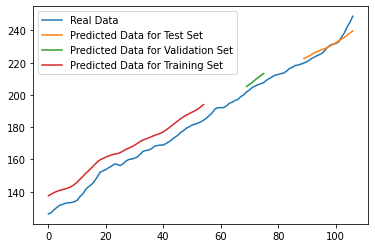

In [169]:
# Plotting everything together
# Setting the intervals 

# shift training predictions for plotting
training_predicted_plot = np.empty_like(df1)
training_predicted_plot[:, :] = np.nan
#training_predicted.shape
training_predicted_plot[0:55, :] = training_predicted

# shift validation predictions for plotting
val_predicted_plot = np.empty_like(df1)
val_predicted_plot[:, :] = np.nan
#validation_predicted.shape
val_predicted_plot[69:76, :] = validation_predicted


# shift test predictions for plotting
test_predicted_plot = np.empty_like(df1)
test_predicted_plot[:, :] = np.nan
#test_predicted.shape
test_predicted_plot[89:107, :] = test_predicted

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label = "Real Data")
plt.plot(test_predicted_plot, label = "Predicted Data for Test Set")
plt.plot(val_predicted_plot, label = "Predicted Data for Validation Set")
plt.plot(training_predicted_plot, label = "Predicted Data for Training Set")
plt.legend()
plt.show()